# Polarizing Movies

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from config.settings import DB_PATH
import data_processing.load_sqlite as load_sql

In [2]:
df = load_sql.fetch_user_movie_ratings()
df.head()

,user_id,movielens_id,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


## Overall Distribution of Ratings

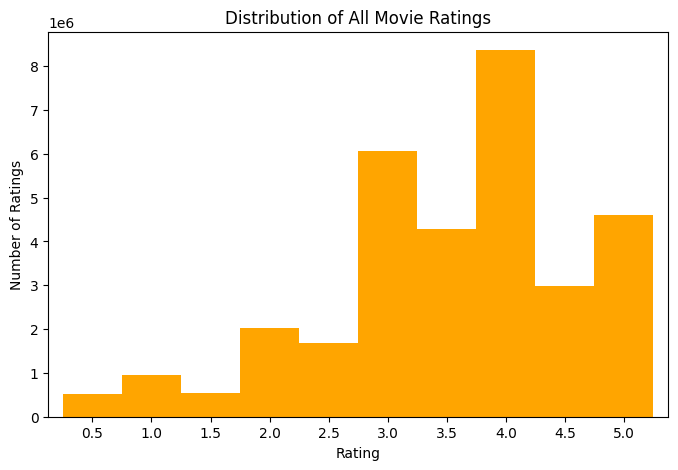

In [3]:
plt.figure(figsize=(8, 5))
df["rating"].value_counts().sort_index().plot(kind="bar", color="orange", width=1)
plt.title("Distribution of All Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.xticks(rotation=0)
plt.show()

## Looking for the right metric

In [6]:
def plot_most_polarizing_distributions(df_polarizing, Num_plots=36):
    # Get the top N polarizing movies
    top_movies = df_polarizing.head(Num_plots)["movielens_id"].tolist()

    # Create a grid for subplots
    cols = 6
    rows = Num_plots // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 3.5 * rows))  # Adjust size dynamically
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    # Plot each movie's rating distribution
    for i, movie_id in enumerate(top_movies):
        ax = axes[i]
        
        # Get ratings for the current movie
        ratings = df[df["movielens_id"] == movie_id]["rating"]
        
        # Plot histogram with seaborn
        sns.histplot(ratings, discrete=True, kde=False, ax=ax, color="orange")
        
        # Set title (replace movie_id with actual title if available)
        ax.set_title(f"Movie {movie_id} Rating Distribution", fontsize=12)
        ax.set_xlabel("Rating")
        ax.set_ylabel("Count")
        ax.set_xticks(range(1, 6))
    
    # Hide unused subplots 
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

### Standard Deviation 

In [4]:
min_rating_count = 15

In [5]:
df_polarizing = df.groupby("movielens_id")["rating"].agg(["count", "mean", "std"]).reset_index()
df_polarizing = df_polarizing[df_polarizing["count"] > min_rating_count]  
df_polarizing.sort_values(by="std", ascending=False, inplace=True)
df_pol_std = df_polarizing
df_pol_std.head()

,movielens_id,count,mean,std
39158,159423,17,1.970588,1.964295
14718,78064,18,3.166667,1.917412
55112,194680,31,2.612903,1.904861
73739,254034,16,3.375000,1.875278
11271,49872,31,2.951613,1.863486


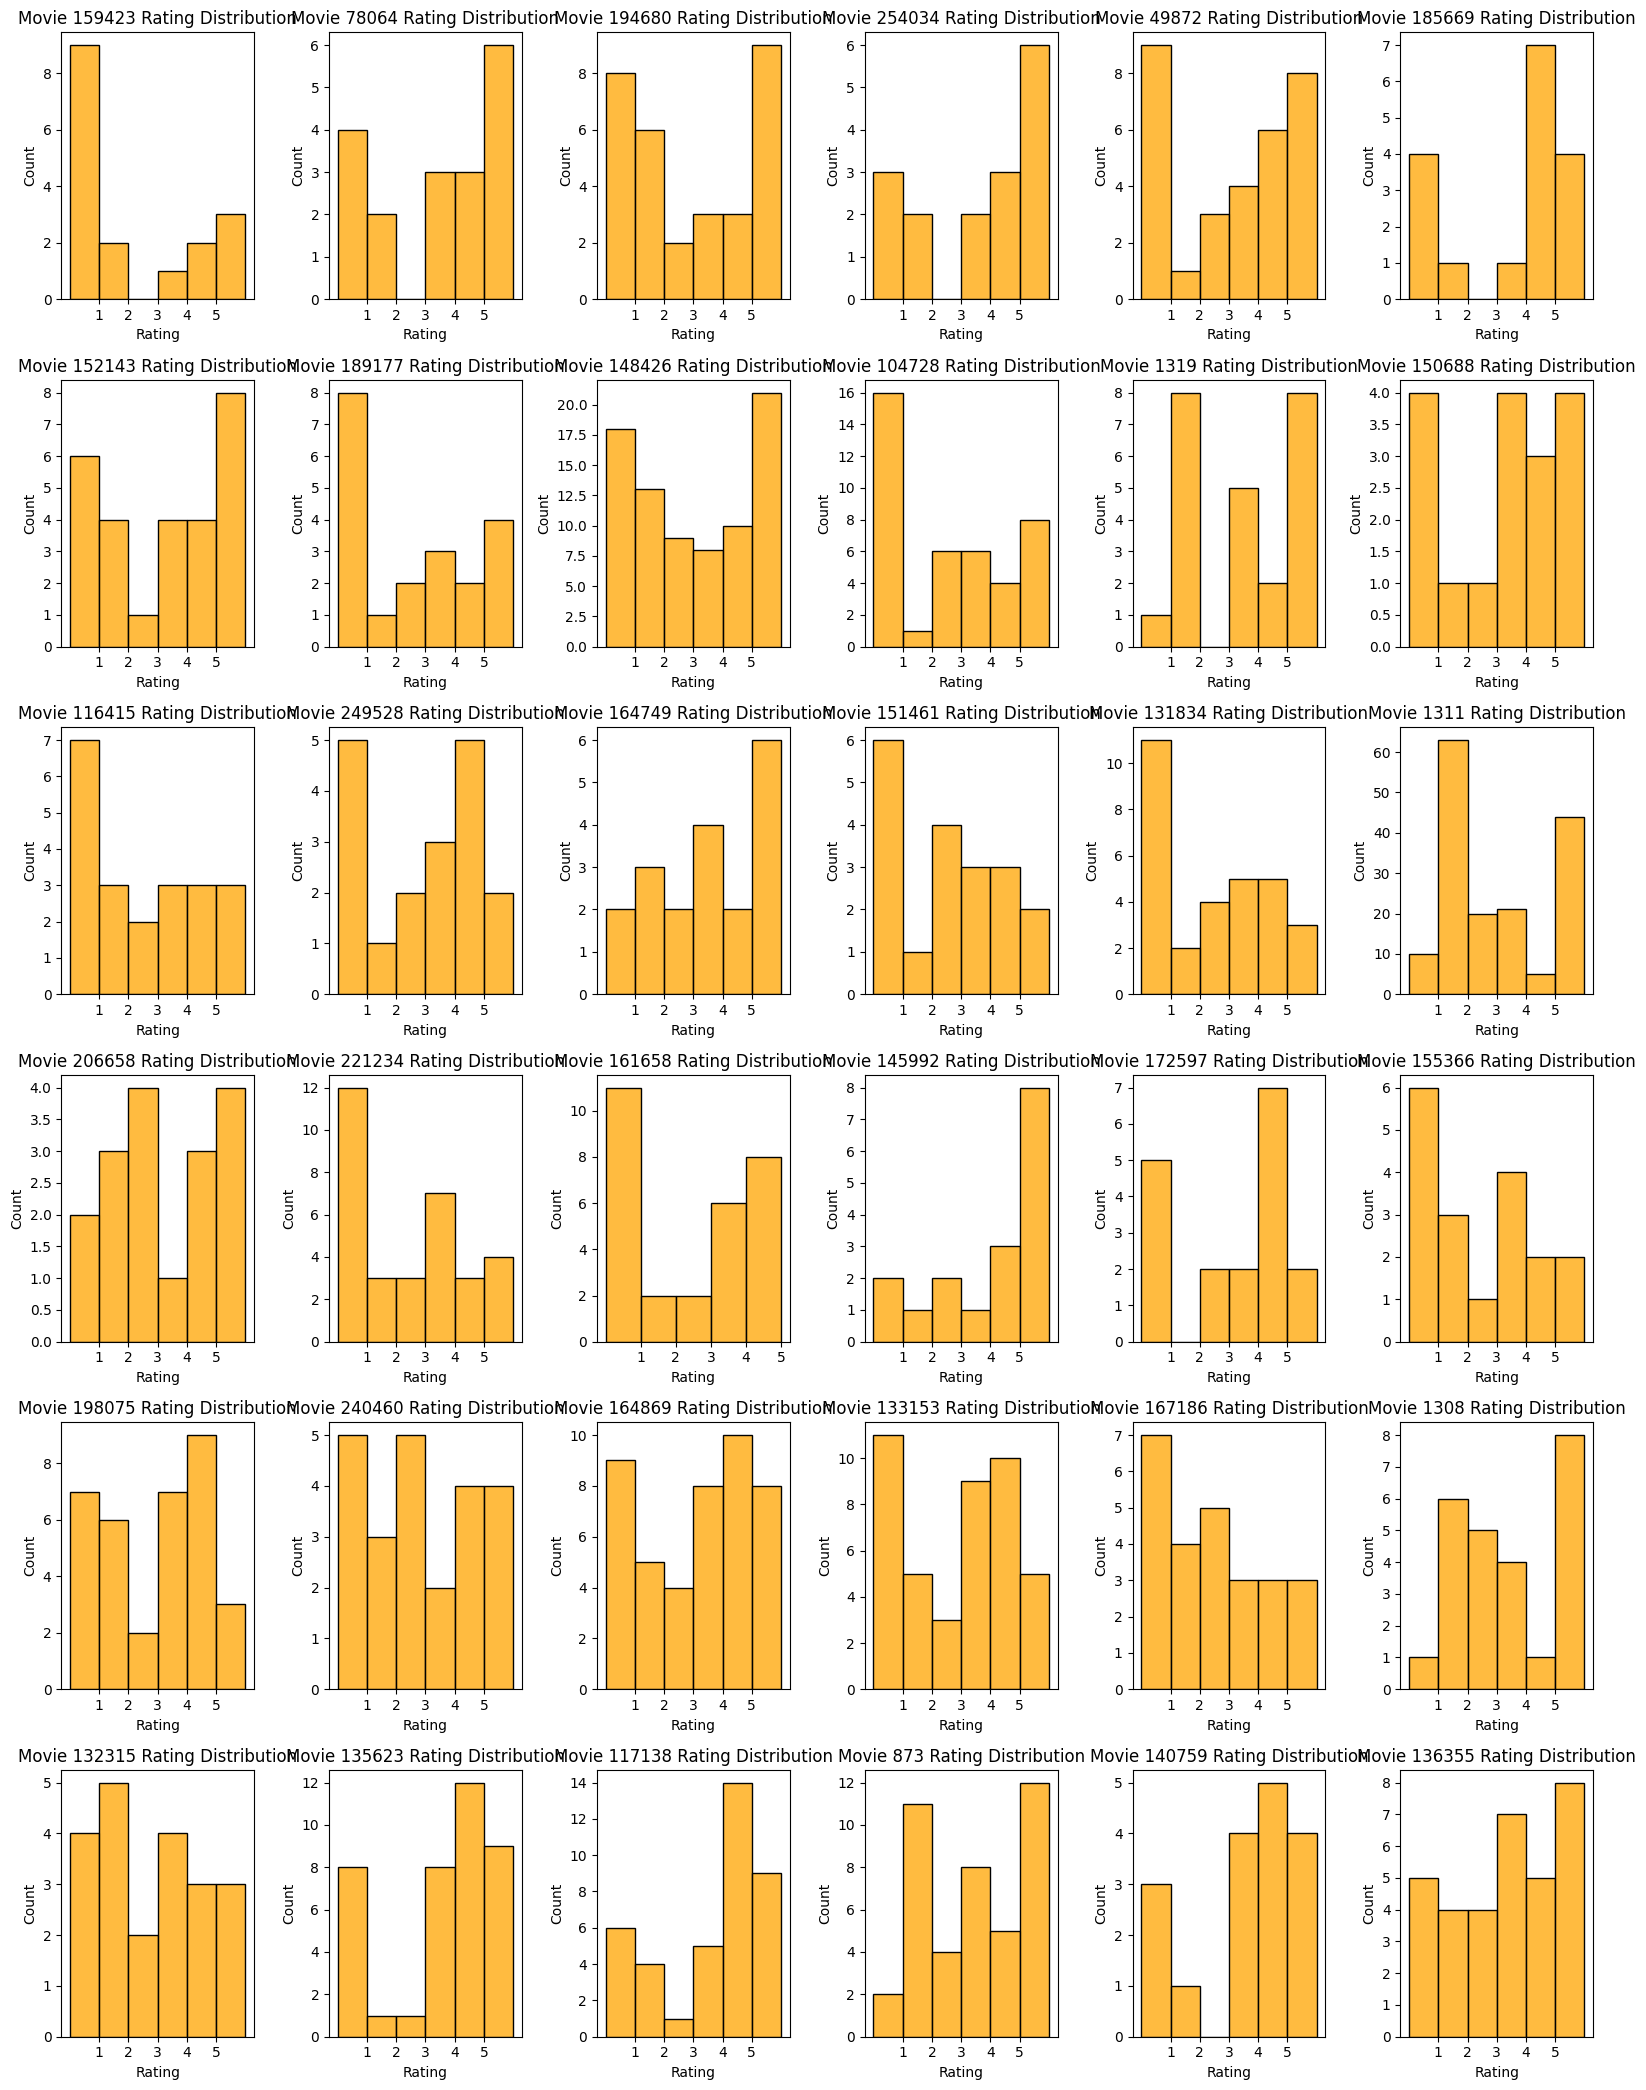

In [7]:
plot_most_polarizing_distributions(df_pol_std)

### Bipolarity Score

In [8]:
def bipolarity_score(x):
    num_low = (x <= 1.5).sum()
    num_high = (x >= 4).sum()
    num_mid = len(x) - num_low - num_high
    if num_mid > min(num_low, num_high) or 1.5*min(num_low, num_high) < max(num_low, num_high) :
        return 0
    return (num_low + num_high) / len(x)

df_polarizing = df.groupby("movielens_id")["rating"].agg(["count", "mean", bipolarity_score]).reset_index()
df_polarizing = df_polarizing[df_polarizing["count"] > min_rating_count]
df_polarizing.sort_values(by="bipolarity_score", ascending=False, inplace=True)
df_pol_bp = df_polarizing
df_pol_bp.head(36)

,movielens_id,count,mean,bipolarity_score
55112,194680,31,2.612903,0.838710
14718,78064,18,3.166667,0.833333
36173,152143,27,2.962963,0.814815
1285,1319,24,2.979167,0.791667
57856,200568,24,2.895833,0.791667
34762,148426,79,2.753165,0.784810
9488,31053,18,2.277778,0.777778
11271,49872,31,2.951613,0.774194
52595,189177,20,2.350000,0.750000
1277,1311,163,2.552147,0.748466


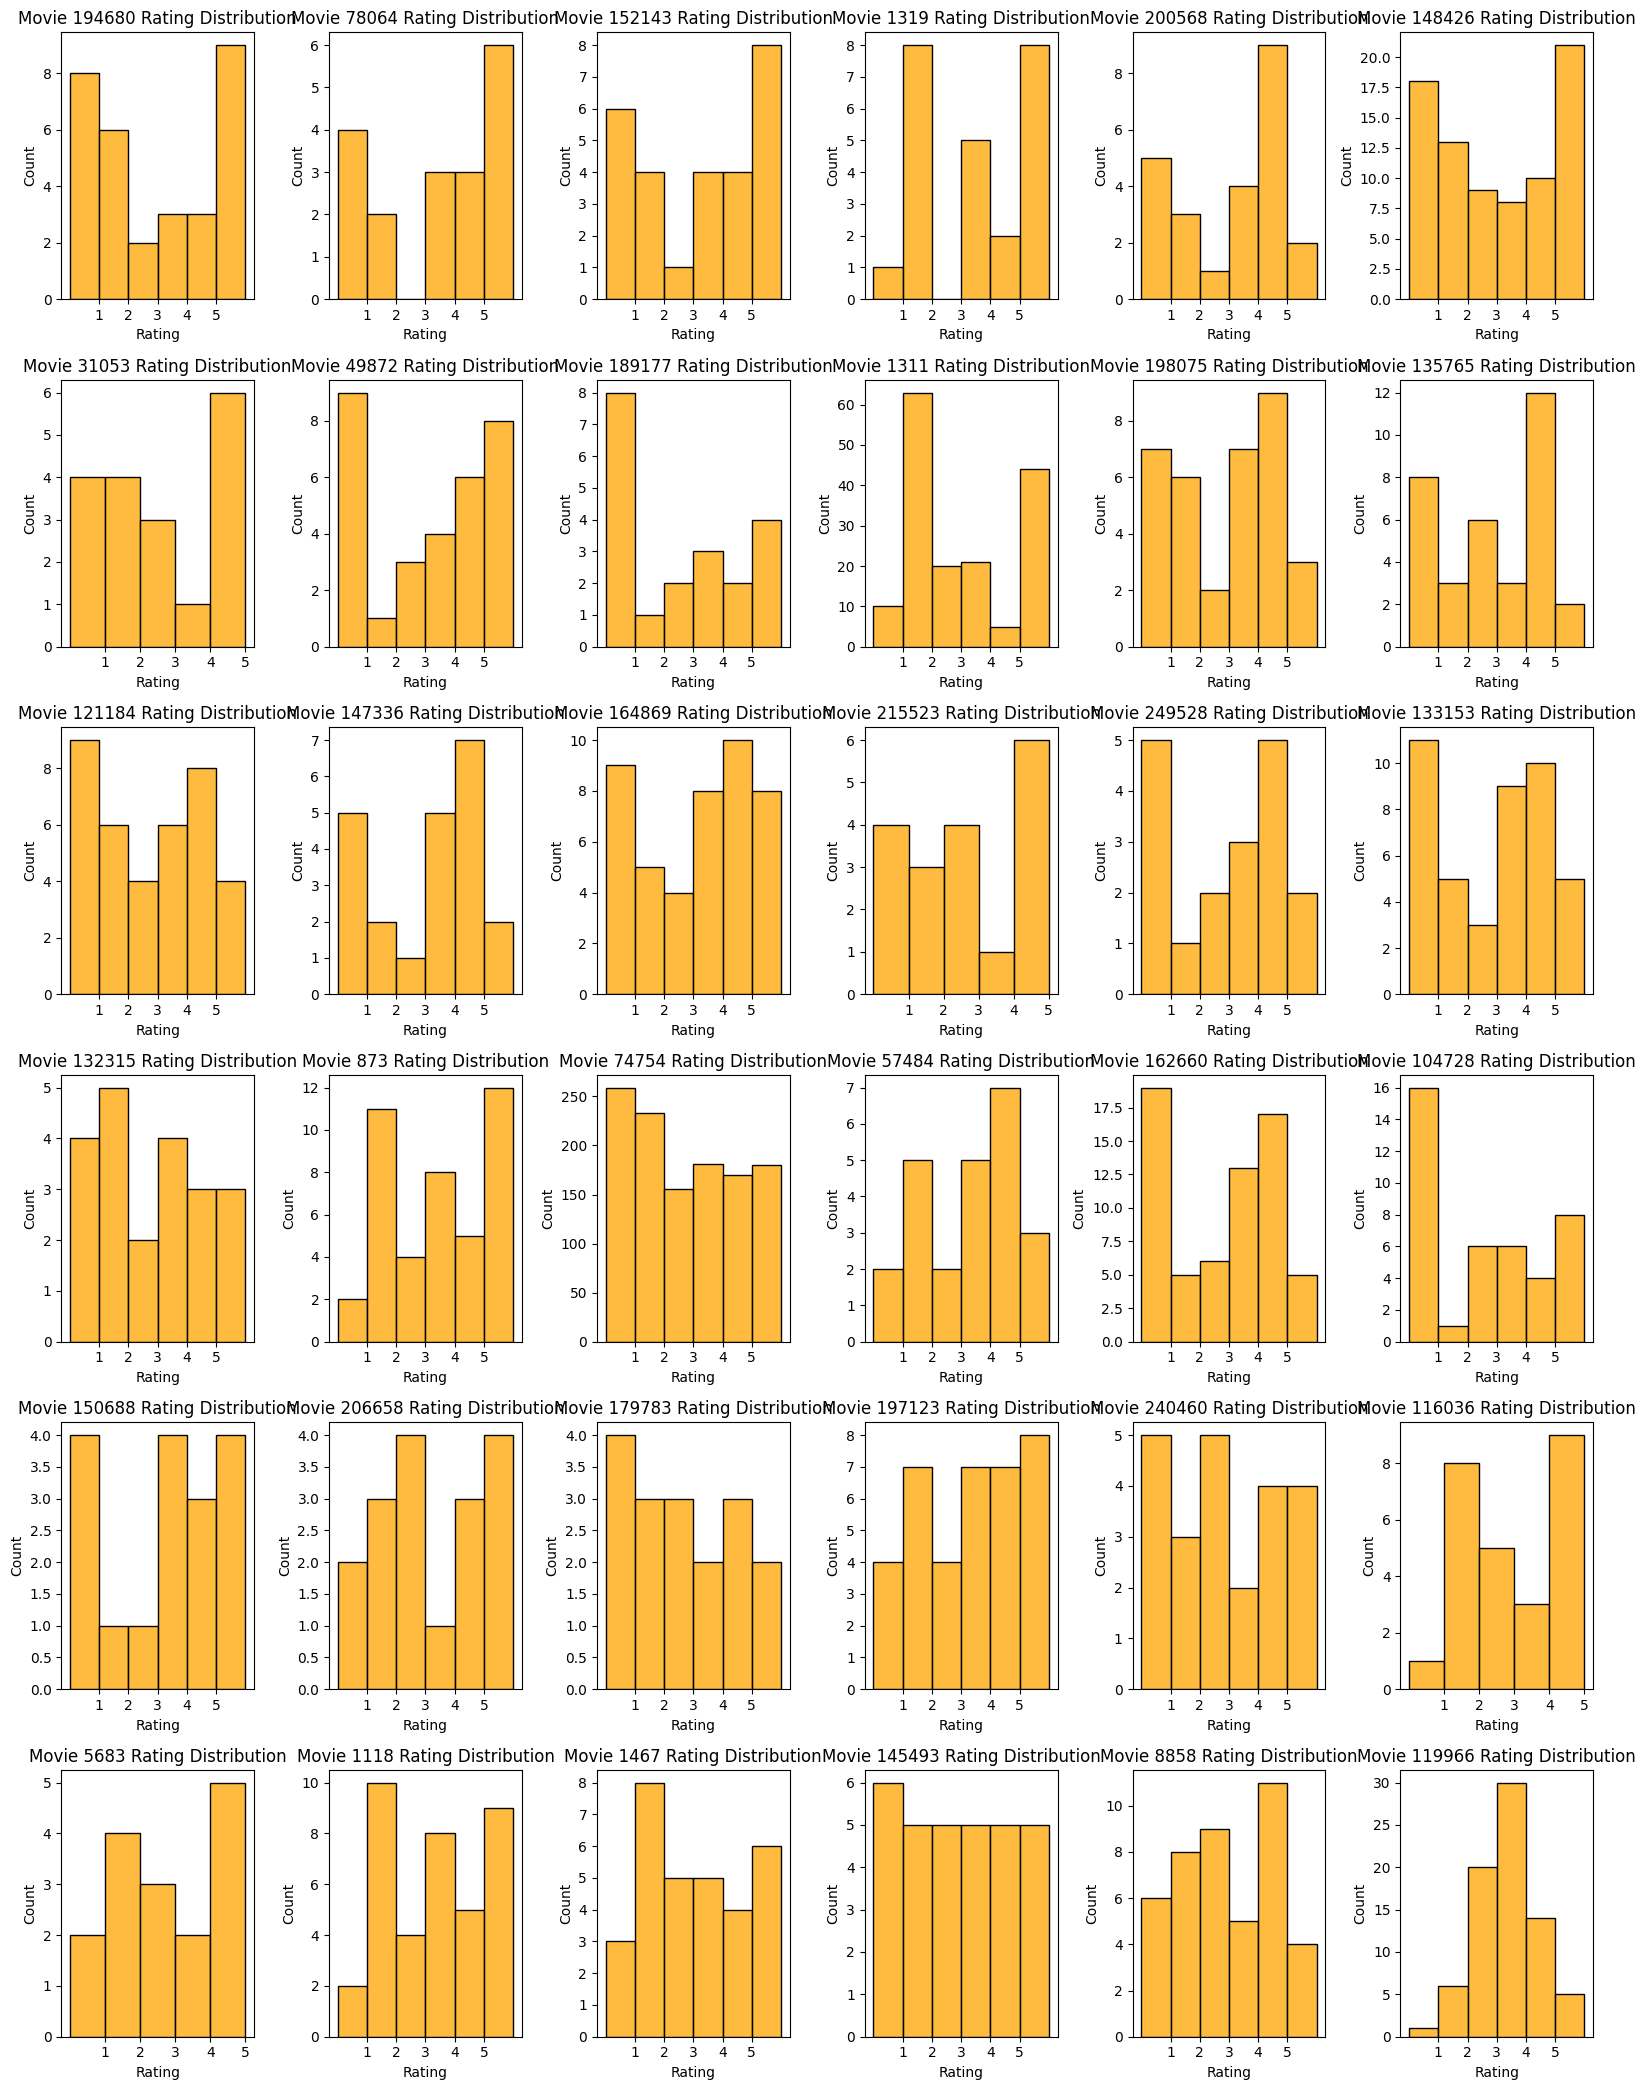

In [9]:
plot_most_polarizing_distributions(df_pol_bp)

In [23]:
movielens_ids = tuple(df_pol_bp['movielens_id'].head(35)) 

query = f"""
        SELECT title FROM movie
        WHERE movie_id IN (
            SELECT tmdb_id FROM movie_link
            WHERE movielens_id IN ({",".join(["?"] * len(movielens_ids))})
        )
        """

with sqlite3.connect(DB_PATH) as conn:
    cursor = conn.cursor()
    cursor.execute(query, movielens_ids)
    titles = cursor.fetchall()

for i, t in zip(movielens_ids, titles):
    print(i, t[0])

194680 Save the Last Dance 2
78064 Shadow of Angels
152143 Loose Change
1319 The Room
200568 The Prince & Me: A Royal Honeymoon
148426 What the Bleep! Down the Rabbit Hole
31053 Children of the Corn: Revelation
49872 Santa with Muscles
189177 3 Bad Men
1311 Ween: Live in Chicago
198075 The Challenge
135765 The Apple
121184 Hansel & Gretel
147336 Salut cousin !
164869 American Pie: Revealed
215523 Heart of America
249528 Vishwaroopam
133153 One Direction: This Is Us
132315 Barbie in the Pink Shoes
873 Fateful Findings
74754 North Star
57484 Tomorrow Was the War
162660 Plastic Galaxy: The Story of Star Wars Toys
104728 Love on a Leash
150688 Kids of Survival
206658 God's Not Dead 2
179783 A Cinderella Story: If the Shoe Fits
197123 Recep Ivedik 5
240460 Let There Be Light
116036 Valley Girl
5683 Twisted Pair
1118 Balkan Line
1467 Taylor Swift: Reputation Stadium Tour
145493 Unplanned
8858 After We Fell


### Variance to mean ratio (VMR)

In [10]:
df_polarizing = df.groupby("movielens_id")["rating"].agg(["count", "mean", "var"]).reset_index()
df_polarizing["vmr"] = df_polarizing["var"] / df_polarizing["mean"]
df_polarizing = df_polarizing[df_polarizing["count"] > min_rating_count]
df_polarizing.sort_values(by="vmr", ascending=False, inplace=True)
df_pol_vmr = df_polarizing
df_pol_vmr.head()

,movielens_id,count,mean,var,vmr
39158,159423,17,1.970588,3.858456,1.958022
50955,185659,18,1.027778,1.660948,1.616057
8191,8904,17,1.647059,2.430147,1.475446
52595,189177,20,2.350000,3.371053,1.434490
33484,145096,72,1.180556,1.671166,1.415576


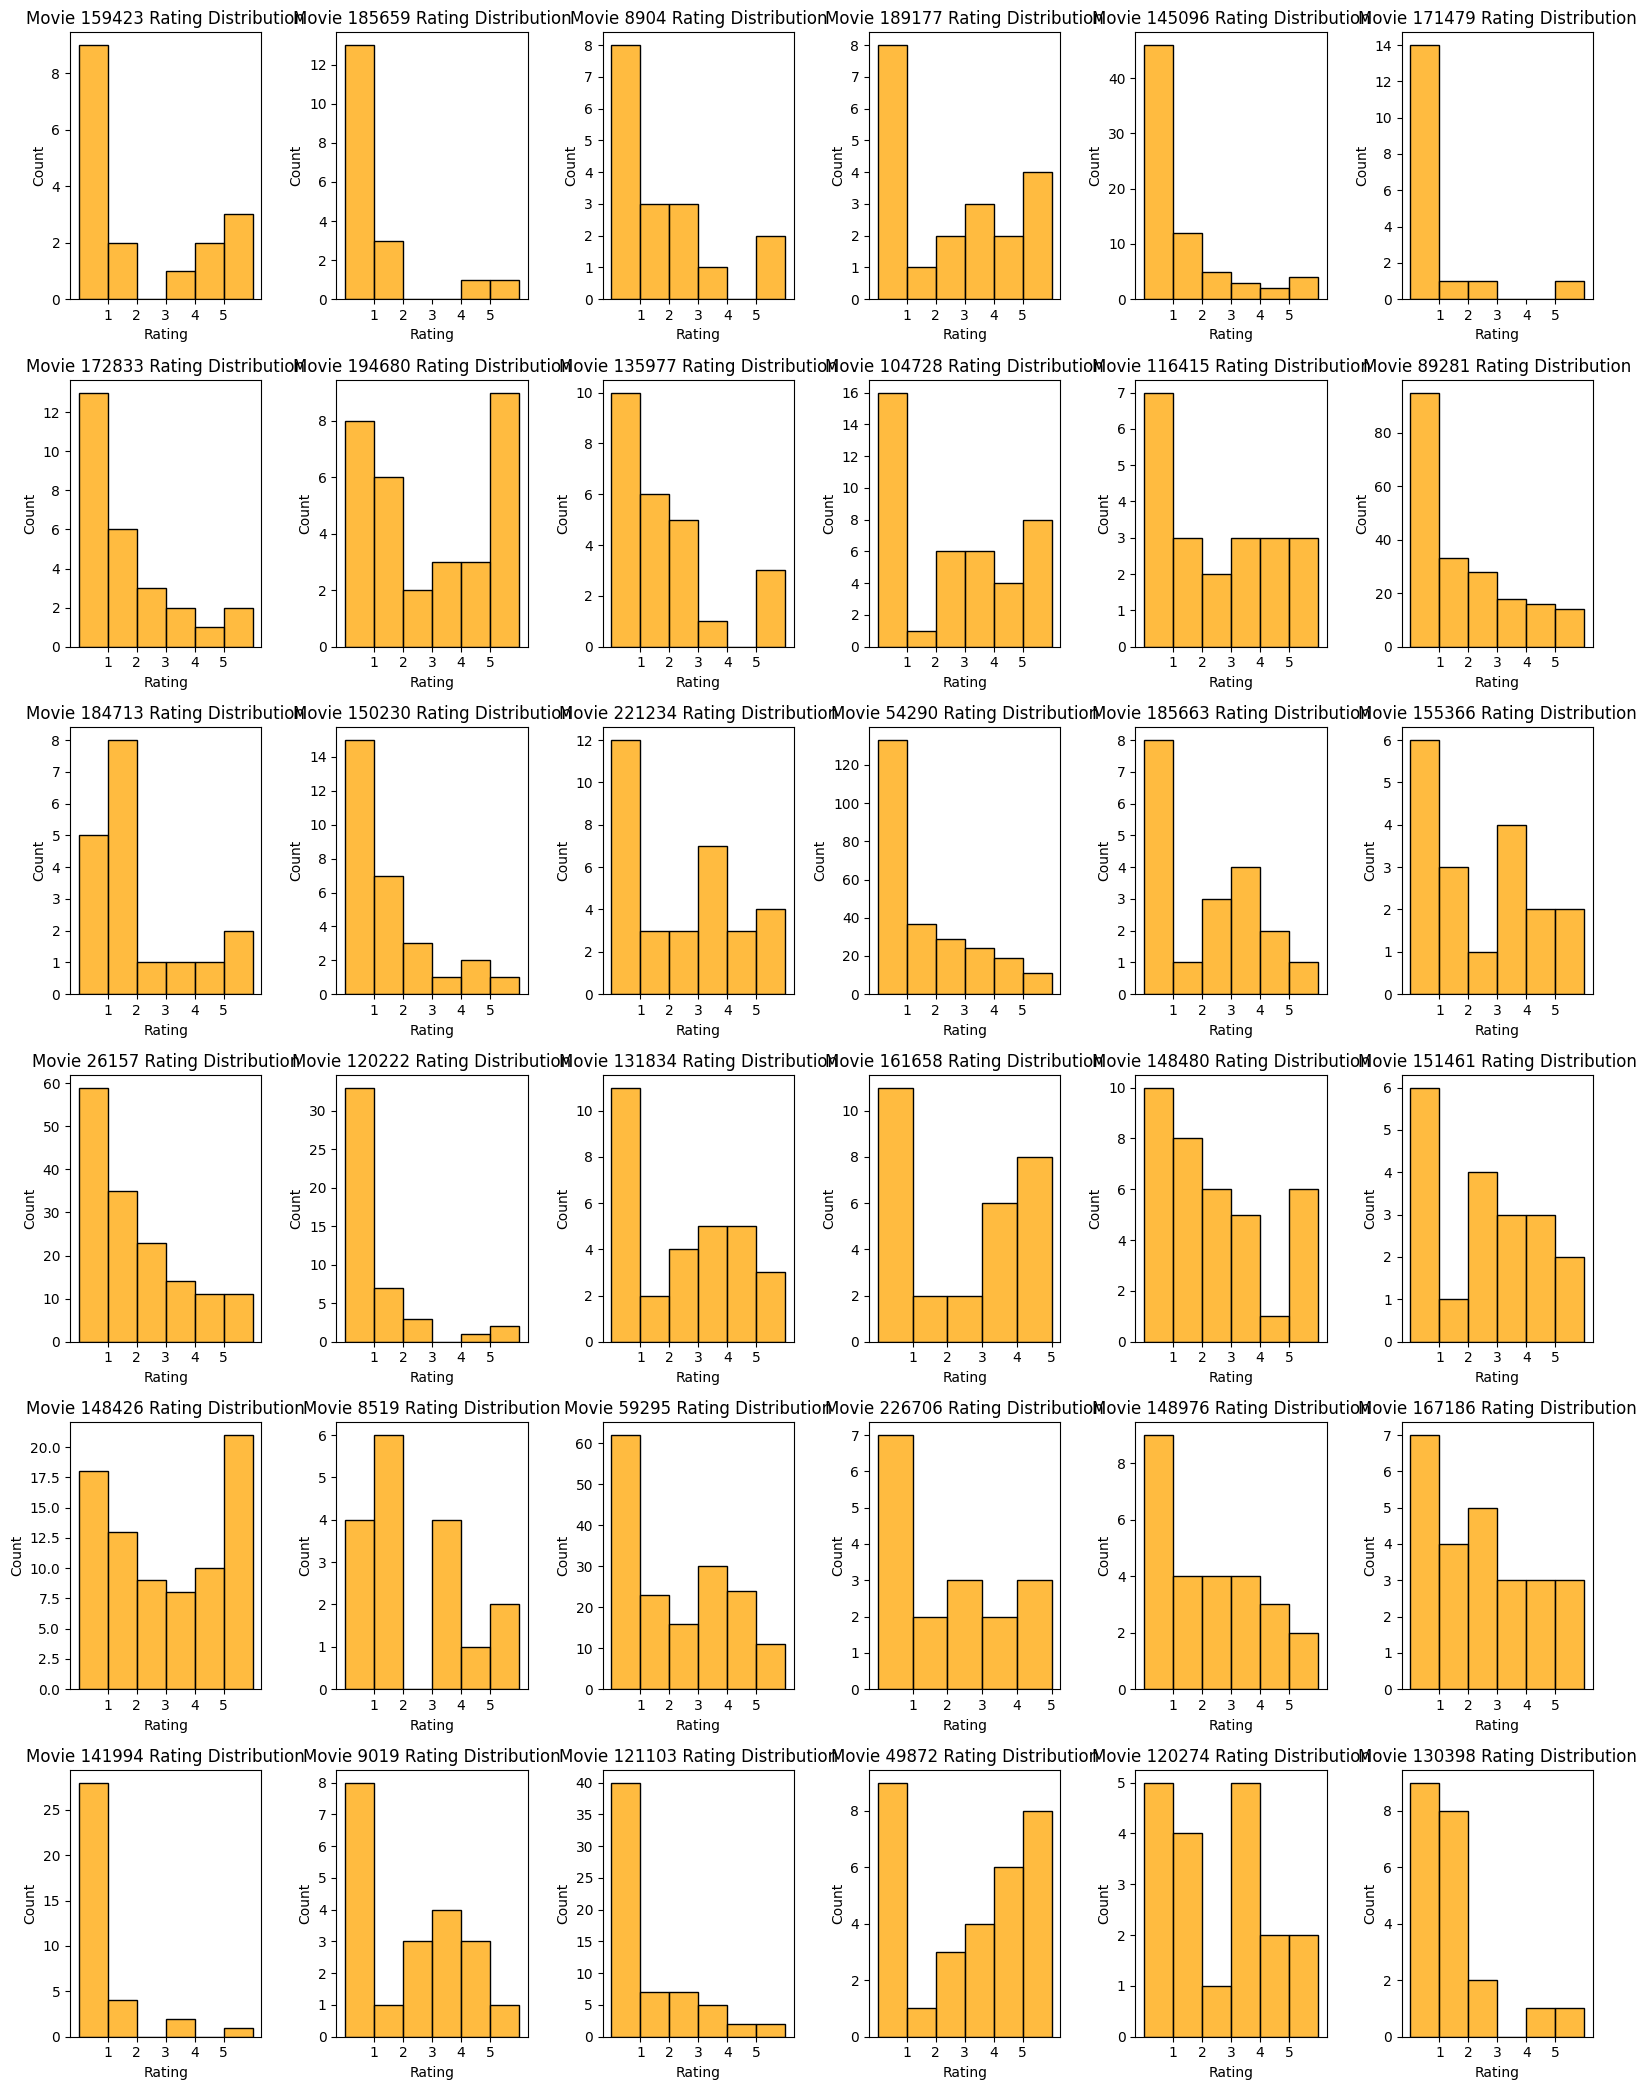

In [11]:
plot_most_polarizing_distributions(df_pol_vmr)

### Interquartile Range (IQR)

In [12]:
df_polarizing = df.groupby("movielens_id")["rating"].agg(["count", "median",
    lambda x: x.quantile(0.75) - x.quantile(0.25)]).reset_index()
df_polarizing.columns = ["movielens_id", "count", "median_rating", "iqr"]
df_polarizing = df_polarizing[df_polarizing["count"] > min_rating_count]
df_polarizing.sort_values(by="iqr", ascending=False, inplace=True)
df_pol_iqr = df_polarizing
df_pol_iqr.head()

,movielens_id,count,median_rating,iqr
11271,49872,31,3.50,4.25
55112,194680,31,2.00,4.25
1277,1311,163,2.00,4.00
854,873,42,3.00,4.00
14718,78064,18,3.75,4.00


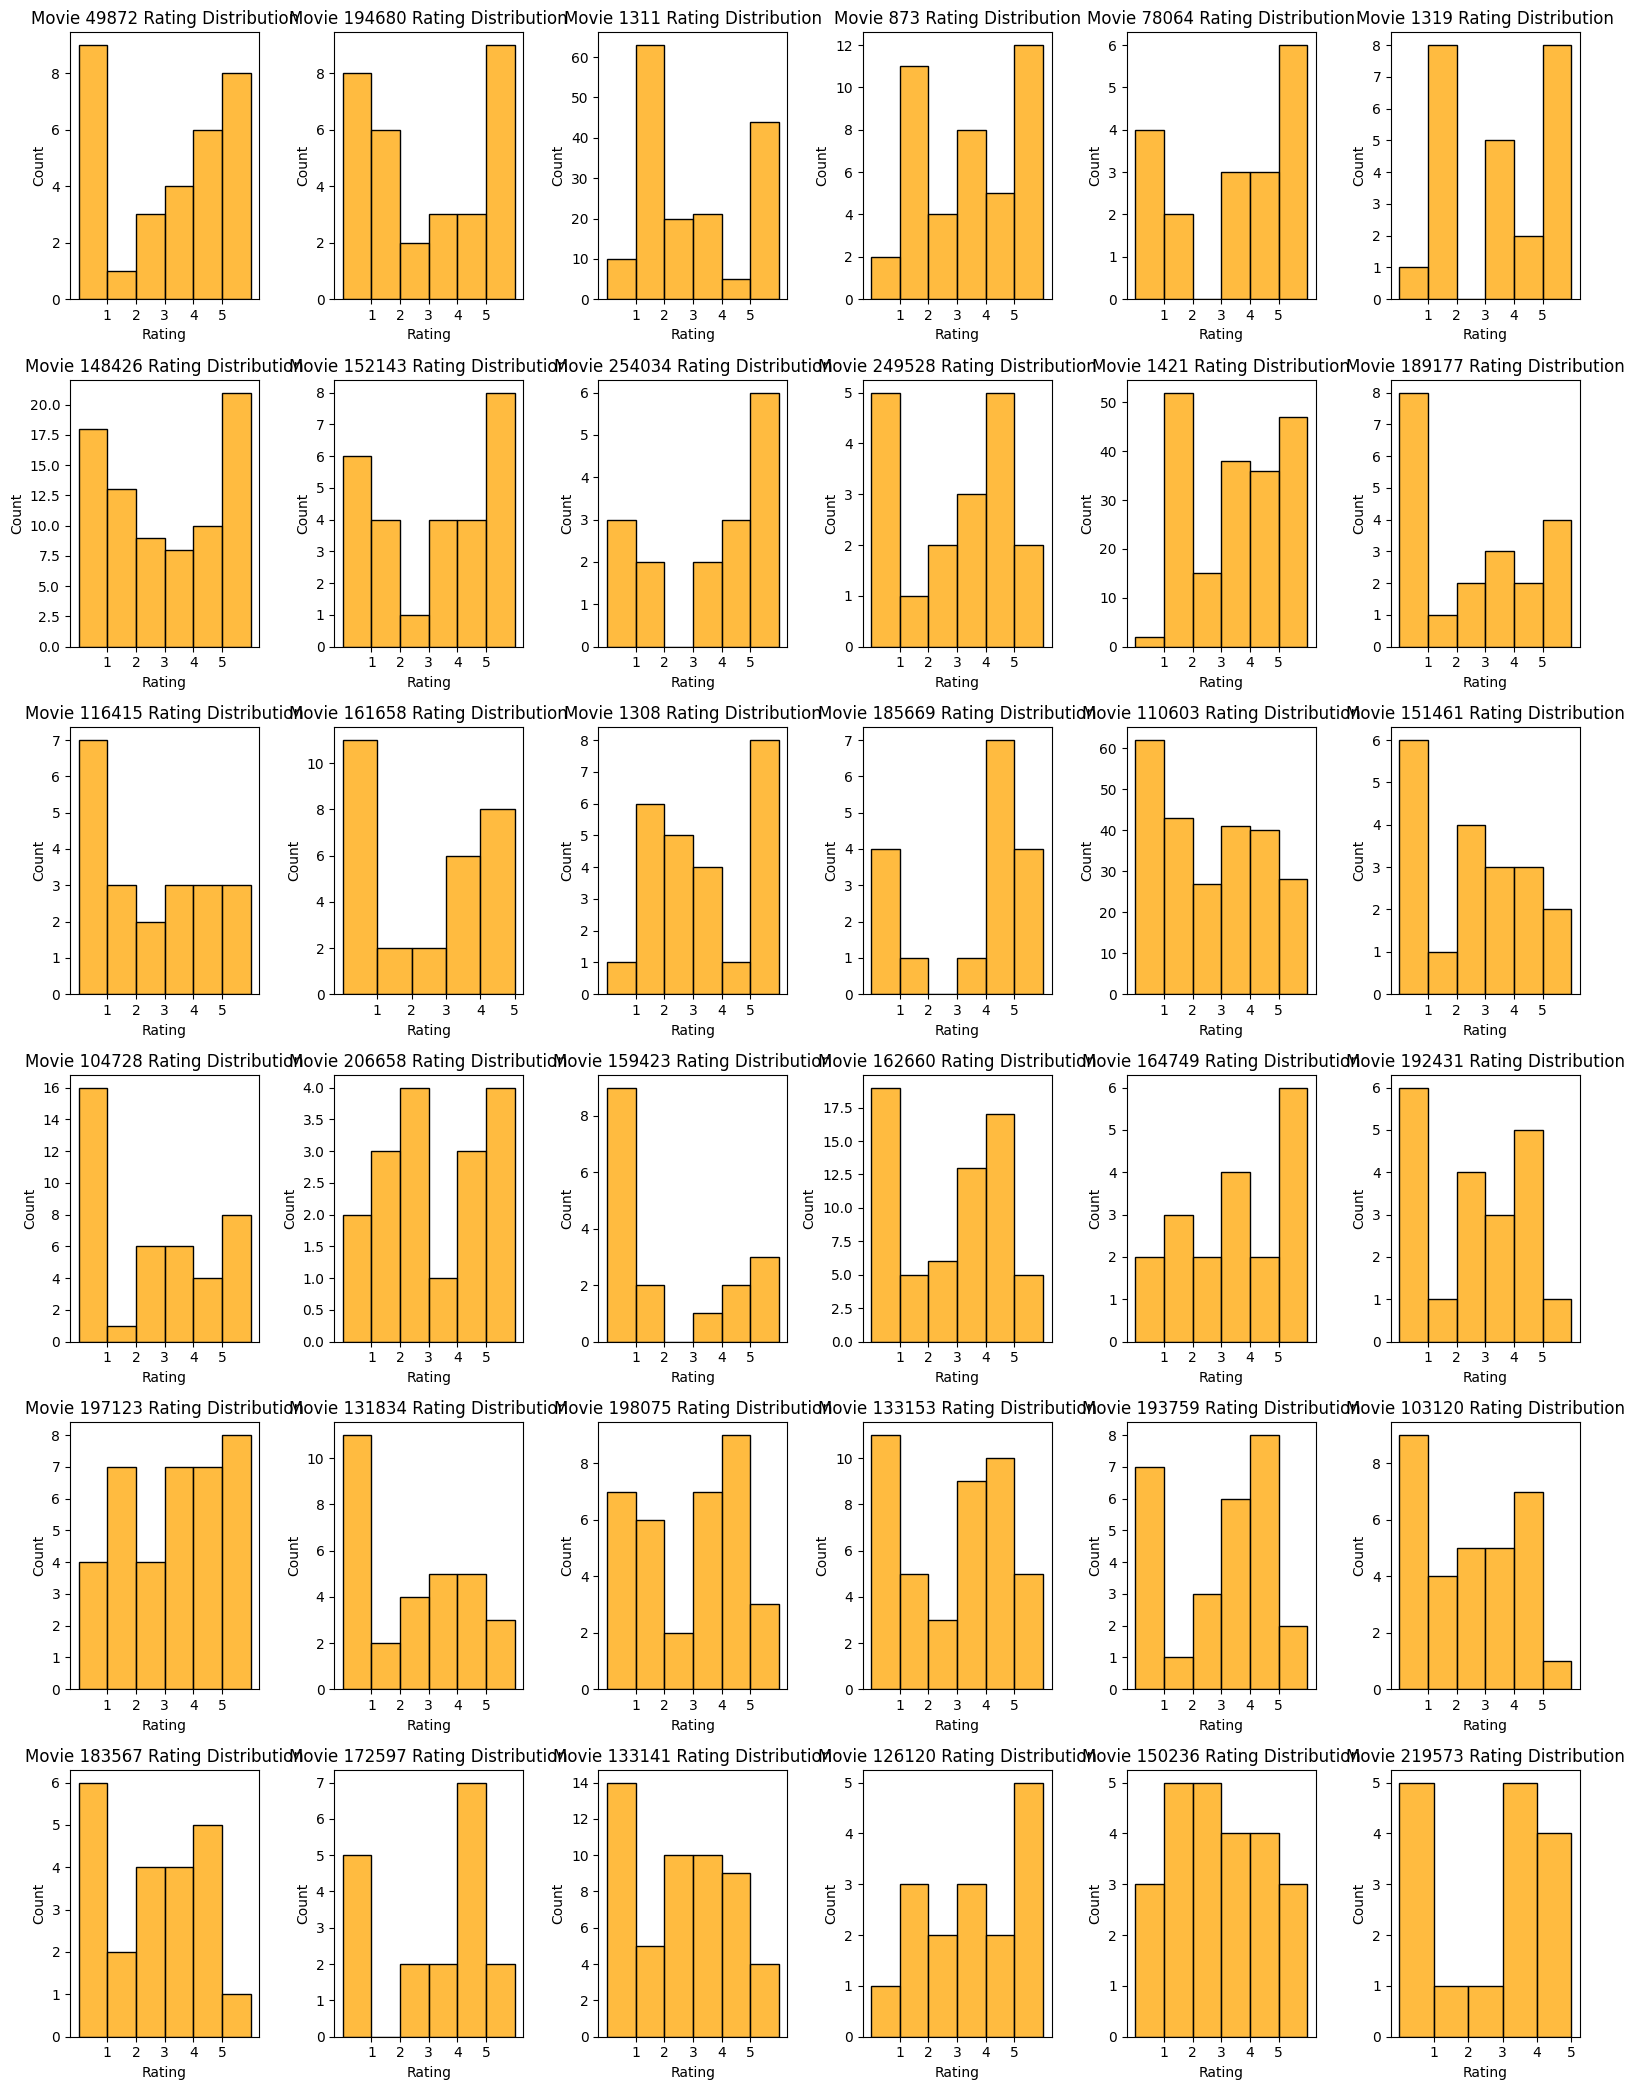

In [13]:
plot_most_polarizing_distributions(df_pol_iqr)